In [3]:
import tensorflow as tf

In [4]:
import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [8]:
disease_type = ['Healthy','Jasid','Powdery']
data_path = 'E:/Crop_disease/dataset/datasets/Mixed/Okra/'
train_dir = os.path.join(data_path)

In [9]:
os.listdir(train_dir)

['Healthy', 'Jasid', 'Powdery']

In [10]:
train_data = []
for id, sp in enumerate(disease_type):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [14]:
train.head(500)

,File,DiseaseID,Disease Type
0,Healthy/IMG20221012194121.jpg,0,Healthy
1,Powdery/IMG20221013103124.jpg,2,Powdery
2,Healthy/IMG20221012200335.jpg,0,Healthy
3,Powdery/IMG20221012215941.jpg,2,Powdery
4,Powdery/IMG20221012190632.jpg,2,Powdery
...,...,...,...
495,Powdery/IMG20221013093243.jpg,2,Powdery
496,Powdery/IMG20221012192131.jpg,2,Powdery
497,Powdery/IMG20221012220418.jpg,2,Powdery
498,Jasid/IMG_20221013_100036.jpg,1,Jasid


In [15]:
len(train)

1503

In [16]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Healthy/IMG20221012194721.jpg,0,Healthy
1,Powdery/IMG20221012215639.jpg,2,Powdery
2,Powdery/IMG20221013102731.jpg,2,Powdery
3,Jasid/IMG20221013151122.jpg,1,Jasid
4,Powdery/IMG20221012190449.jpg,2,Powdery


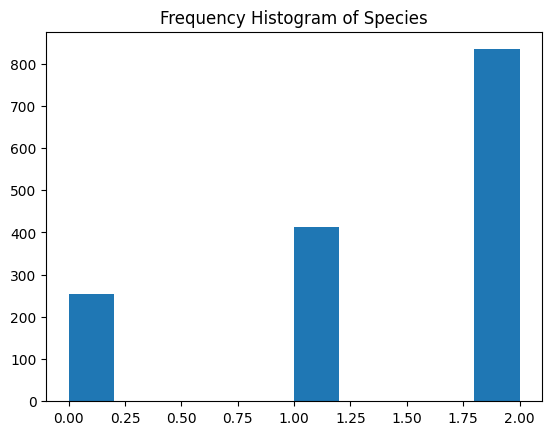

<Figure size 1200x1200 with 0 Axes>

In [17]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

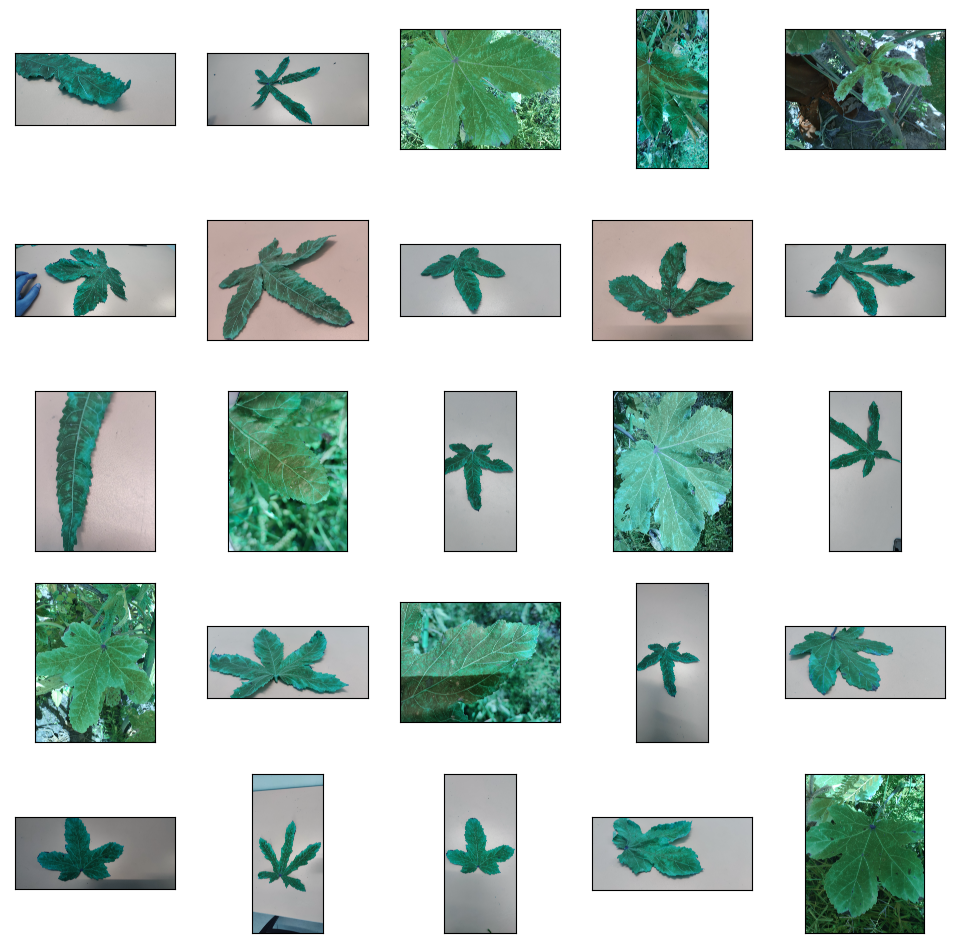

In [18]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_path, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Jasid', 5, 5)

In [19]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_path, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [20]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

1503it [11:14,  2.23it/s]

Train Shape: (1503, 64, 64, 3)


In [22]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [23]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

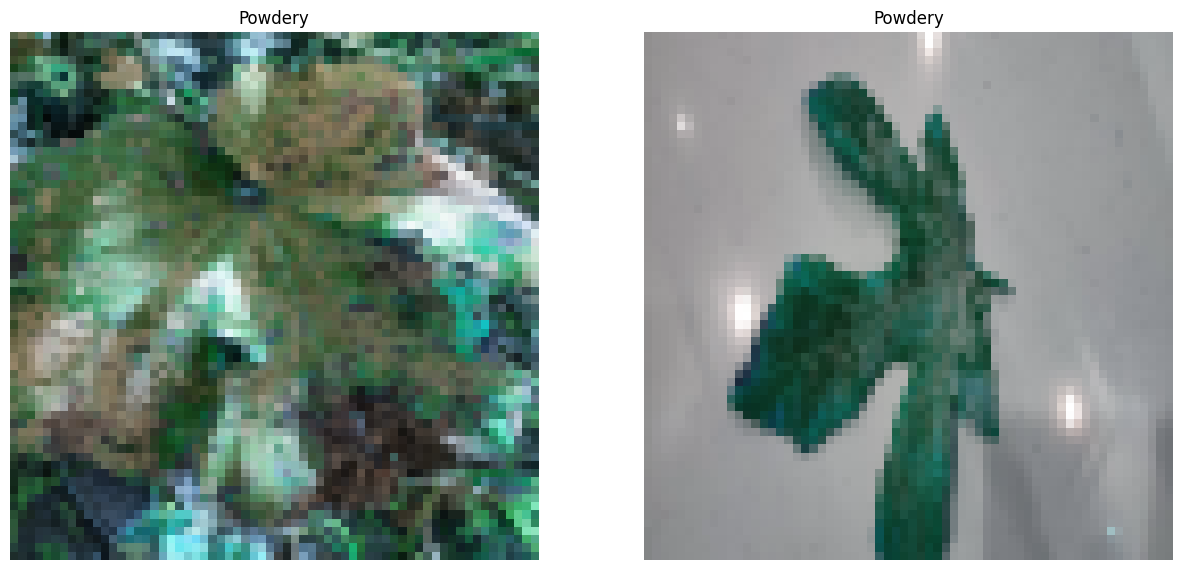

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
for i in range(2):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_type[np.argmax(Y_train[i])])

In [25]:
EPOCHS = 100
SIZE=64
N_ch=3

In [26]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(3,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [27]:
from collections import Counter
print(Counter(train['Disease Type']))

Counter({'Powdery': 834, 'Jasid': 414, 'Healthy': 255})


In [30]:
class_weights = {0:255/1503, 1:414/1503, 2:834/1503}

In [31]:
class_weights

{0: 0.16966067864271456, 1: 0.2754491017964072, 2: 0.5548902195608783}

In [33]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=16),
               steps_per_epoch=X_train.shape[0] // 16,
               epochs=100,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val),
               class_weight = class_weights)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0   

Epoch 33/100

Epoch 33: val_loss did not improve from 0.26300
75/75 - 12s - loss: 0.1067 - accuracy: 0.8550 - val_loss: 0.4147 - val_accuracy: 0.8272 - lr: 0.0010 - 12s/epoch - 155ms/step
Epoch 34/100

Epoch 34: val_loss did not improve from 0.26300
75/75 - 12s - loss: 0.1076 - accuracy: 0.8710 - val_loss: 0.3477 - val_accuracy: 0.8538 - lr: 0.0010 - 12s/epoch - 158ms/step
Epoch 35/100

Epoch 35: val_loss did not improve from 0.26300
75/75 - 12s - loss: 0.1416 - accuracy: 0.8196 - val_loss: 0.9238 - val_accuracy: 0.7276 - lr: 0.0010 - 12s/epoch - 155ms/step
Epoch 36/100

Epoch 36: val_loss did not improve from 0.26300
75/75 - 12s - loss: 0.1267 - accuracy: 0.8196 - val_loss: 0.4244 - val_accuracy: 0.8173 - lr: 0.0010 - 12s/epoch - 155ms/step
Epoch 37/100

Epoch 37: val_loss improved from 0.26300 to 0.24928, saving model to model.h5
75/75 - 13s - loss: 0.1166 - accuracy: 0.8322 - val_loss: 0.2493 - val_accuracy: 0.8837 - lr: 0.0010 - 13s/epoch - 177ms/step
Epoch 38/100

Epoch 38: val_lo

75/75 - 12s - loss: 0.0948 - accuracy: 0.8752 - val_loss: 0.1617 - val_accuracy: 0.9302 - lr: 0.0010 - 12s/epoch - 159ms/step
Epoch 77/100

Epoch 77: val_loss did not improve from 0.15759
75/75 - 12s - loss: 0.0834 - accuracy: 0.8845 - val_loss: 0.3034 - val_accuracy: 0.8671 - lr: 0.0010 - 12s/epoch - 157ms/step
Epoch 78/100

Epoch 78: val_loss did not improve from 0.15759
75/75 - 12s - loss: 0.0846 - accuracy: 0.8786 - val_loss: 0.3757 - val_accuracy: 0.8505 - lr: 0.0010 - 12s/epoch - 156ms/step
Epoch 79/100

Epoch 79: val_loss did not improve from 0.15759
75/75 - 12s - loss: 0.1585 - accuracy: 0.8010 - val_loss: 0.5101 - val_accuracy: 0.8372 - lr: 0.0010 - 12s/epoch - 155ms/step
Epoch 80/100

Epoch 80: val_loss did not improve from 0.15759
75/75 - 12s - loss: 0.1224 - accuracy: 0.8246 - val_loss: 0.2924 - val_accuracy: 0.8804 - lr: 0.0010 - 12s/epoch - 163ms/step
Epoch 81/100

Epoch 81: val_loss did not improve from 0.15759
75/75 - 12s - loss: 0.1137 - accuracy: 0.8440 - val_loss: 0.

In [34]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

10/10 [==============================] - 1s 77ms/step - loss: 0.3852 - accuracy: 0.8671
Final Loss: 0.38519978523254395, Final Accuracy: 0.8671096563339233


10/10 [==============================] - 6s 78ms/step


Text(0.5, 192.72222222222217, 'Predicted')

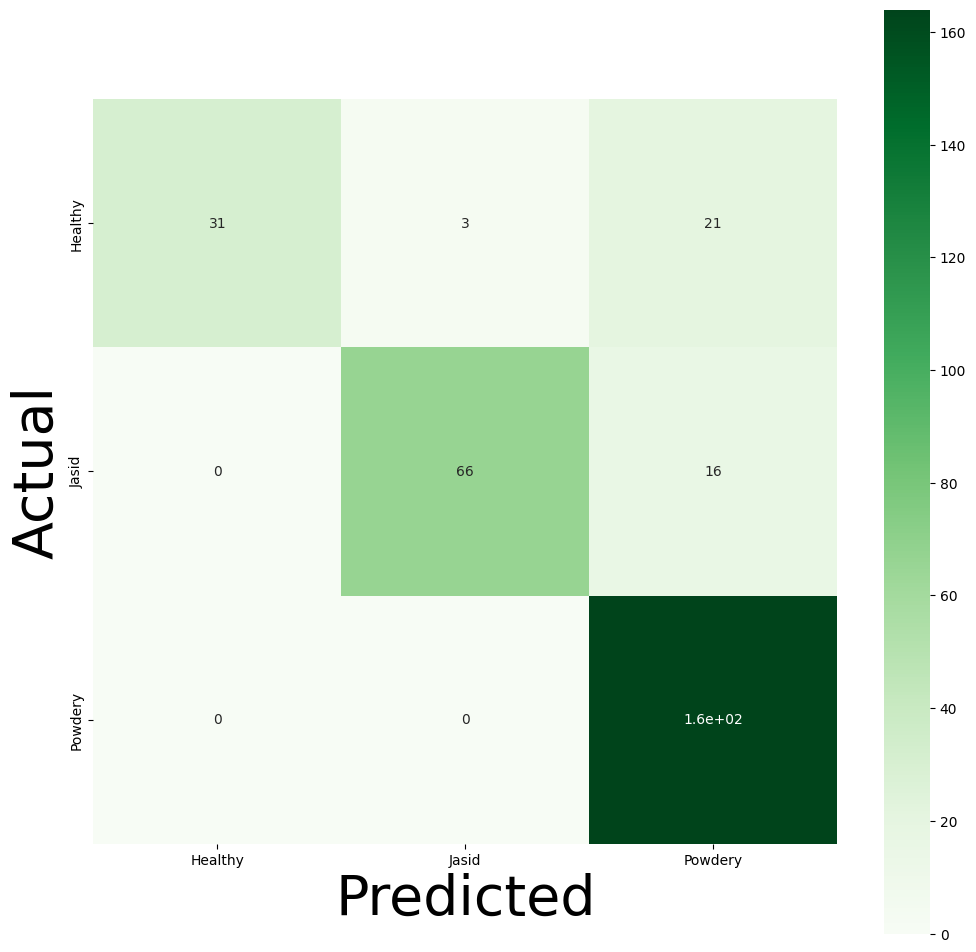

In [35]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_type, yticklabels=disease_type)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

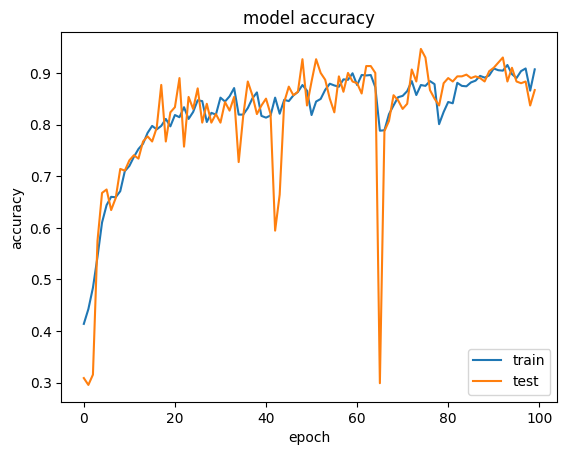

In [36]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

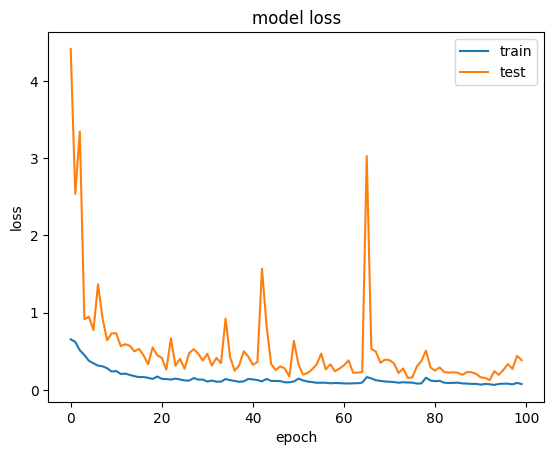

In [37]:
# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()